In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import transformers #huggingface transformers library

from sklearn import metrics # for classification report
from sklearn.model_selection import train_test_split # train/test split feature
from sklearn.preprocessing import LabelEncoder 
from transformers import TFAutoModel, AutoTokenizer
from sklearn.metrics import confusion_matrix, hamming_loss, f1_score # Model Performance metrics
from tensorflow.keras.callbacks import EarlyStopping # Helps stopping training when the model does not improve over a certain value
from tensorflow_addons.metrics import F1Score # F1 fFor model.compile stage
from sklearn.utils import class_weight # Calculating class weights as we have imbalanced classes

encoder = LabelEncoder() # encoding labels
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased') # bert base tokenizer

2024-03-17 10:38:58.362654: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/suhas.kamuni/Library/Python/3.9/lib/python/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [27]:
pip show tensorflow tensorflow_addons

Name: tensorflow
Version: 2.14.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Users/suhas.kamuni/Library/Python/3.9/lib/python/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: tensorflow-text
---
Name: tensorflow-addons
Version: 0.23.0
Summary: TensorFlow Addons.
Home-page: UNKNOWN
Author: Google Inc.
Author-email: opensource@google.com
License: Apache 2.0
Location: /Users/suhas.kamuni/Library/Python/3.9/lib/python/site-packages
Requires: packaging, typeguard
Required-by: 
---
Name: transformers
Version: 4.34.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home

In [28]:
pip show transformers

Name: transformers
Version: 4.34.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /Users/suhas.kamuni/Library/Python/3.9/lib/python/site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: bert-extractive-summarizer, sentence-transformers
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [6]:
df = pd.read_excel('/Users/suhas.kamuni/Downloads/Merged_Training_Set.xlsx')
df.drop(df.loc[(df['Predicted Team']=='CPAY')].index, inplace=True)
df.drop(['Platform.1'], axis = 1)

,Review ID,Reviews Content,Converted English,Rating,Start Date,Version,Platform,Source,Month,Predicted Team
0,158994127,Keine vernünftige Struktur wie bei Web Version...,Not a reasonable structure as with web version...,1,21.10.2022,NaN,Android,EasyFeedback,September,People/Homepage
1,158999921,Ich finde vorher war übersicht besser.,I think before was overview better.,2,21.10.2022,NaN,Android,EasyFeedback,September,Design System
2,159009543,Teilweise mühsame Navigation,Partly tedious navigation,3,22.10.2022,NaN,Android,EasyFeedback,September,General
3,159010950,Unpraktische Bedienung,Impractical operation,2,22.10.2022,NaN,Android,EasyFeedback,September,General
4,159033855,"Mich stört, dass laufend irgendwelche Besucher...",It bothers me that some visitors can constantl...,2,22.10.2022,NaN,Android,EasyFeedback,September,Profile
...,...,...,...,...,...,...,...,...,...,...
1861,180738858,Gesendete Kontaktanfragen sind über die App ni...,Sent contact requests cannot be accessed via t...,2,2023-09-11 00:00:00,NaN,iOS,EasyFeedback,September,People/Homepage
1862,182164129,Freundschaftsanfragen werden in der App bei mi...,Friendship requests are not displayed in the app.,2,2023-09-27 00:00:00,NaN,iOS,EasyFeedback,September,Premium
1863,181028450,Finde es in der App sehr schwer meine Kontakte...,I find it very difficult to find my contacts/n...,3,2023-09-14 00:00:00,NaN,Android,EasyFeedback,September,Profile
1864,182097301,Dazernd unpasende und bereits abgelehnte Konta...,Dazern unsuitable and already rejected contact...,2,2023-09-26 00:00:00,NaN,Android,EasyFeedback,September,Reference to Groups


# Pretraining BERT

In [7]:
#label encoding the categories. After this each category would be mapped to an integer.
df['categoryEncoded'] = encoder.fit_transform(df['Predicted Team'])
df['Converted English'] = df['Converted English'].apply(lambda descr: str(descr).lower())
df['descr_len'] = df['Converted English'].apply(lambda x: len(str(x).split()))
df.head()

,Review ID,Reviews Content,Converted English,Rating,Start Date,Version,Platform,Platform.1,Source,Month,Predicted Team,categoryEncoded,descr_len
0,158994127,Keine vernünftige Struktur wie bei Web Version...,not a reasonable structure as with web version...,1,21.10.2022,NaN,Android,Android,EasyFeedback,September,People/Homepage,9,27
1,158999921,Ich finde vorher war übersicht besser.,i think before was overview better.,2,21.10.2022,NaN,Android,Android,EasyFeedback,September,Design System,2,6
2,159009543,Teilweise mühsame Navigation,partly tedious navigation,3,22.10.2022,NaN,Android,Android,EasyFeedback,September,General,3,3
3,159010950,Unpraktische Bedienung,impractical operation,2,22.10.2022,NaN,Android,Android,EasyFeedback,September,General,3,2
4,159033855,"Mich stört, dass laufend irgendwelche Besucher...",it bothers me that some visitors can constantl...,2,22.10.2022,NaN,Android,Android,EasyFeedback,September,Profile,11,14


In [8]:
df['descr_len'].describe()

count    1829.000000
mean       17.797157
std        19.257835
min         1.000000
25%         6.000000
50%        12.000000
75%        23.000000
max       202.000000
Name: descr_len, dtype: float64

<Axes: ylabel='Density'>

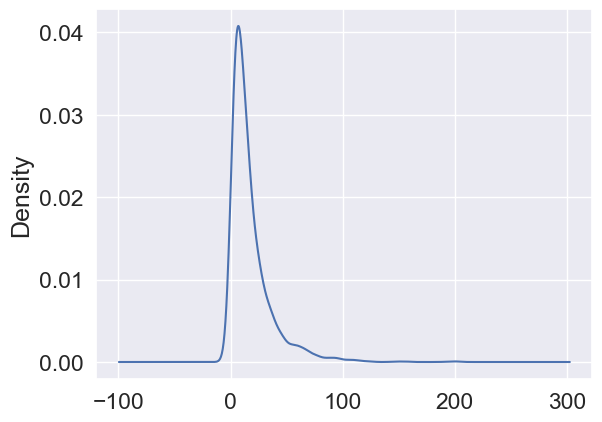

In [32]:
df['descr_len'].plot(kind = 'kde')

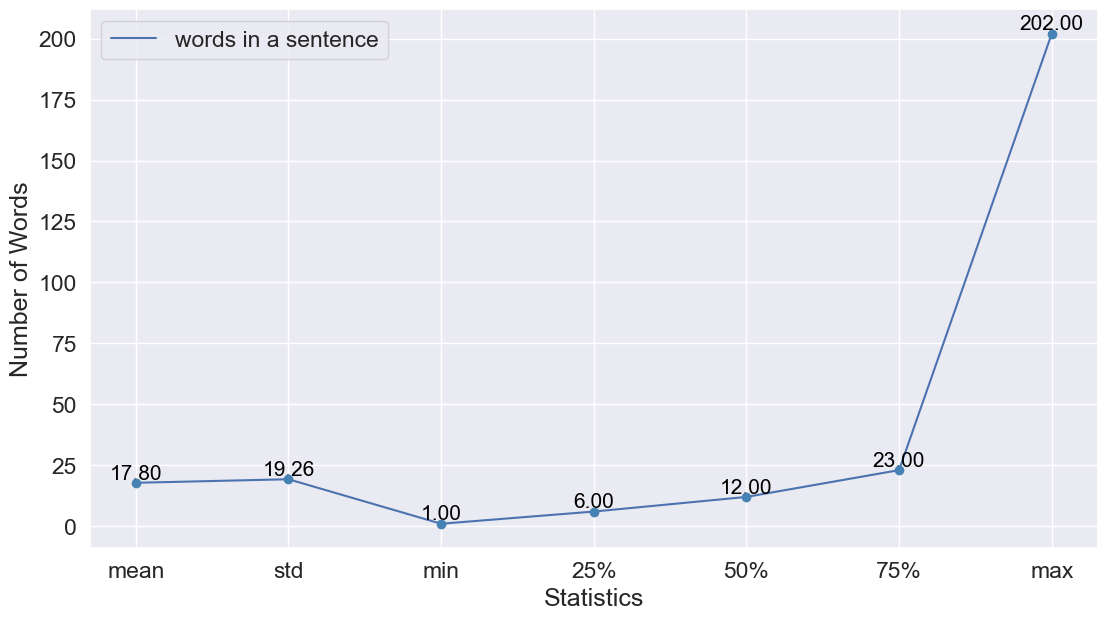

In [31]:
sns.set(font_scale=1.5)
# Assume 'df' is a pre-existing DataFrame

# Extracts the Series of descriptive statistics and drops 'count' and 'max'
descr_stats = df['descr_len'].describe().drop(['count'])

# Create a line plot
fig, ax = plt.subplots(figsize=(13, 7))

# Plot the line
descr_stats.plot(kind='line', ax=ax , label = 'words in a sentence')

# Add scatter dots for each statistic point and annotate them with their respective values
for idx, value in descr_stats.items():
    # Adding the scatter dot
    ax.scatter(idx, value, color='steelblue', zorder=5)
    # Annotating the point with its value
    ax.text(idx, value, '{:.2f}'.format(value), color='black', ha='center', fontsize=15, va='bottom')

# Show the plot
#plt.title("Word count in review statistics")
plt.ylabel("Number of Words")
plt.xlabel('Statistics')
plt.legend()
plt.xticks(range(len(descr_stats)), descr_stats.index)  # Set x-ticks to the statistics' names
plt.show()

In [10]:
df.groupby('Predicted Team')['descr_len'].describe()

,count,mean,std,min,25%,50%,75%,max
Predicted Team,,,,,,,,
Ads,94.0,23.936170,25.942786,2.0,8.25,15.0,32.00,195.0
Content Architecture,82.0,22.341463,20.440954,3.0,10.00,15.5,26.00,103.0
Design System,109.0,14.935780,14.759978,2.0,6.00,10.0,19.00,86.0
General,684.0,9.242690,10.115418,1.0,3.00,6.0,12.00,110.0
Insights,93.0,17.344086,21.302936,1.0,6.00,11.0,21.00,156.0
Jobs,100.0,30.710000,29.038218,2.0,12.00,22.0,43.25,202.0
LinkedIn comparison,68.0,10.808824,6.793890,2.0,6.00,8.0,13.25,30.0
Messenger,64.0,27.906250,23.314086,3.0,13.00,18.0,37.25,106.0
Notification,58.0,28.413793,22.916350,2.0,11.25,21.0,37.50,108.0


In [11]:
df['categoryEncoded'].value_counts()

categoryEncoded
3     684
9     177
2     109
5     100
0      94
4      93
10     92
1      82
11     78
12     71
6      68
7      64
13     59
8      58
Name: count, dtype: int64

In [12]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_masks=False, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

In [13]:
X = df['Converted English']
y = df['categoryEncoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2023, test_size = 0.165, stratify = y)
X_train.shape , y_train.shape, X_test.shape, y_test.shape

((1527,), (1527,), (302,), (302,))

In [14]:
X_train_encoded = regular_encode(X_train.astype('str'), tokenizer, maxlen = 80)
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes = 14,dtype = 'int32')
X_test_encoded = regular_encode(X_test.astype('str'), tokenizer, maxlen = 80)
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes = 14,dtype = 'int32')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/suhas.kamuni/Library/Python/3.9/lib/python/site-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword

In [15]:
# Assuming you have some validation split ratio
valid_ratio = 0.05
train_items = int(len(X_train_encoded)*(1-valid_ratio))

X_train_dataset = X_train_encoded[:train_items]
y_train_dataset = y_train_encoded[:train_items]

X_valid_dataset = X_train_encoded[train_items:]
y_valid_dataset = y_train_encoded[train_items:]
X_train_dataset.shape, X_valid_dataset.shape

((1450, 80), (77, 80))

In [16]:
#creating the training and testing dataset.
BATCH_SIZE =16*strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE 
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_train_encoded, y_train_encoded))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(X_test_encoded)
    .batch(BATCH_SIZE)
)
valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_valid_dataset, y_valid_dataset))
    .batch(BATCH_SIZE)
)

# Building BERT Model

In [17]:
class BERT_Classification(tf.keras.Model):
    def __init__(self, BERT_model, num_classes, dropout_rate = 0.2):
        super().__init__()
        self.BERT = BERT_model
        self.dropout = tf.keras.layers.Dropout(rate = dropout_rate)
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')
        
    def call(self, inputs, training = False):
        x = self.BERT(inputs, training = training)[1]
        x = self.dropout(x, training = training)
        return self.fc(x)

with strategy.scope():
    model = TFAutoModel.from_pretrained("bert-base-uncased") # base version of BERT
    classifier = BERT_Classification(model, num_classes=14)

    classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy', # for multiclass, single label classification
    metrics=[F1Score(num_classes=14, average="macro")]
    )

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

# Training

In [18]:
class_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
class_weights = dict(enumerate(class_weights))

early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0.009, patience = 5, verbose = 1)

n_steps = X_train_encoded.shape[0] // BATCH_SIZE

In [19]:
history = classifier.fit(
    train_dataset,
    epochs = 1,
    validation_data = valid_dataset,
    steps_per_epoch = n_steps,
    callbacks=[early_stopping],
    class_weight = class_weights
)

95/95 [==============================] - 551s 6s/step - loss: 2.4467 - f1_score: 0.0633 - val_loss: 2.1807 - val_f1_score: 0.0441


In [20]:
# preds = model.predict(test_dataset,verbose = 1) # making predictions
predictions = classifier.predict(test_dataset,verbose = 1)
pred_classes = np.argmax(predictions, axis = 1) # converting the one hot vector output to a linear numpy array.

encoded_classes = encoder.classes_ # extracting the classes from the label encoder
predicted_category = [encoded_classes[x] for x in pred_classes] # mapping the encoded output to actual categories
true_category = [encoded_classes[x] for x in y_test]  

19/19 [==============================] - 31s 1s/step


In [26]:
print(history.history)

{'loss': [2.446723699569702], 'f1_score': [0.06330423802137375], 'val_loss': [2.18074369430542], 'val_f1_score': [0.04405874386429787]}


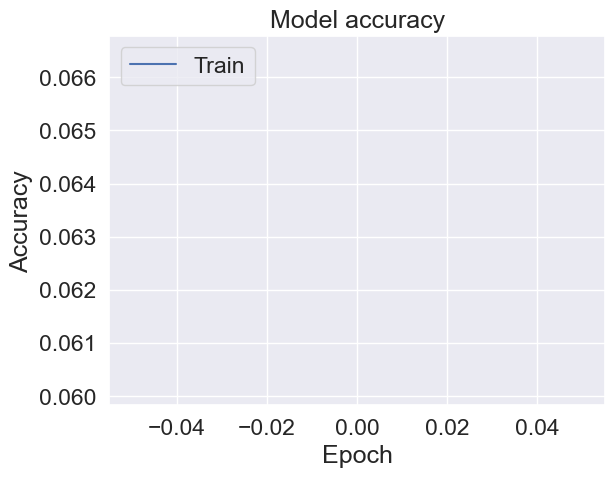

In [22]:
# Plot training & validation accuracy values
plt.plot(history.history['f1_score'], label='Train')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_f1_score'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

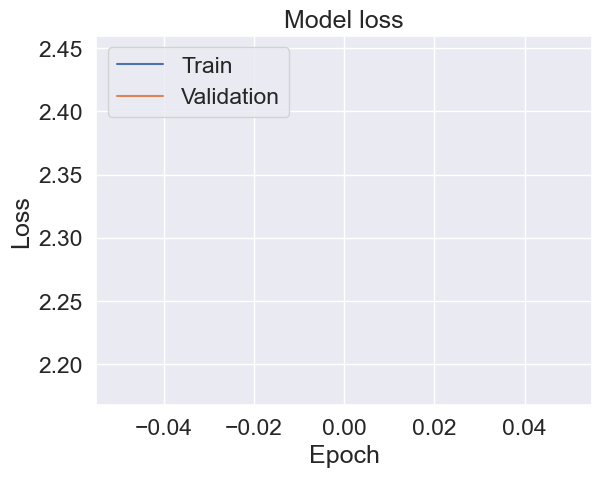

In [23]:
plt.plot(history.history['loss'], label='Train')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Results

In [ ]:
result_df = pd.DataFrame({'description':X_test,'true_category':true_category, 'predicted_category':predicted_category})
result_df

,description,true_category,predicted_category
646,... a partially delayed update (i get push ups...,Profile,Insights
301,"no interesting content, no exchange, too few f...",Insights,Insights
1639,"nobody uses, confusing, like function is boring",General,Insights
453,"the presentation, functionality and use is not...",General,Insights
723,"confusing, timeline of your own contacts no lo...",People/Homepage,Insights
...,...,...,...
1707,unattractive no events members migrate to othe...,Content Architecture,General
109,very confusing after revision and content part...,Insights,General
1328,features that used to be free have been removed,General,General
1352,update march 2023: for several weeks the app c...,Insights,Profile


In [ ]:
result_df[(result_df['true_category']!=result_df['predicted_category'])].sort_index()[:50]

,description,true_category,predicted_category
0,not a reasonable structure as with web version...,People/Homepage,Insights
15,when viewing images (multiple images) in one p...,Content Architecture,Insights
17,"messages are truncated in the app, confusing t...",Messenger,Insights
25,ad split ads in birthday list and other featur...,People/Homepage,Insights
30,"when you open the app, the same posts are alwa...",Content Architecture,Insights
57,"in the past, for example, there was an exact i...",Profile,Ads
63,has not been so active so far. now i watch daily,General,Insights
80,"has been tinkering for years now. confusing, i...",General,Insights
88,i can't read news properly. only the first sen...,Messenger,Insights
92,compared to linkedin and clearer,LinkedIn comparison,General


In [ ]:
result_df[result_df['true_category']!=result_df['predicted_category']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 209 entries, 646 to 815
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   description         209 non-null    object
 1   true_category       209 non-null    object
 2   predicted_category  209 non-null    object
dtypes: object(3)
memory usage: 6.5+ KB


In [ ]:
print('========================== {} ==========================\n'.format(classifier))
print("\t \t \t\t \t------------------")
print("\t \t \t \t \tF1 Score: ", round(f1_score(true_category, predicted_category, average='macro')*100,2),"%")
print("\t \t \t\t \tAccuracy: ", round(metrics.accuracy_score(true_category, predicted_category)*100,2),"%")
print("    \t \t \t \t       Hamming Loss: ", round(hamming_loss(true_category, predicted_category), 2))
print("    \t \t \t \t   Weighted F1 Score: ",round(f1_score(true_category, predicted_category, average='weighted')*100,2),"%")
print("    \t \t \t \t   ---------------------------\n")
print('========================== {} =========================='.format(classifier))

========================== <__main__.BERT_Classification object at 0x14e6a2790> ==========================

	 	 		 	------------------
	 	 	 	 	F1 Score:  5.7 %
	 	 		 	Accuracy:  24.0 %
    	 	 	 	       Hamming Loss:  0.76
    	 	 	 	   Weighted F1 Score:  22.19 %
    	 	 	 	   ---------------------------

========================== <__main__.BERT_Classification object at 0x14e6a2790> ==========================


In [ ]:
print(metrics.classification_report(true_category, predicted_category))

                      precision    recall  f1-score   support

                 Ads       0.06      0.14      0.09        14
Content Architecture       0.00      0.00      0.00        12
       Design System       0.00      0.00      0.00        16
             General       0.57      0.55      0.56       103
            Insights       0.05      0.43      0.09        14
                Jobs       0.00      0.00      0.00        15
 LinkedIn comparison       0.00      0.00      0.00        10
           Messenger       0.00      0.00      0.00        10
        Notification       0.00      0.00      0.00         8
     People/Homepage       0.00      0.00      0.00        27
             Premium       0.00      0.00      0.00        14
             Profile       0.05      0.08      0.06        12
 Reference to Groups       0.00      0.00      0.00        11
              Upsell       0.00      0.00      0.00         9

            accuracy                           0.24       275
      

/Users/suhas.kamuni/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/suhas.kamuni/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/suhas.kamuni/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

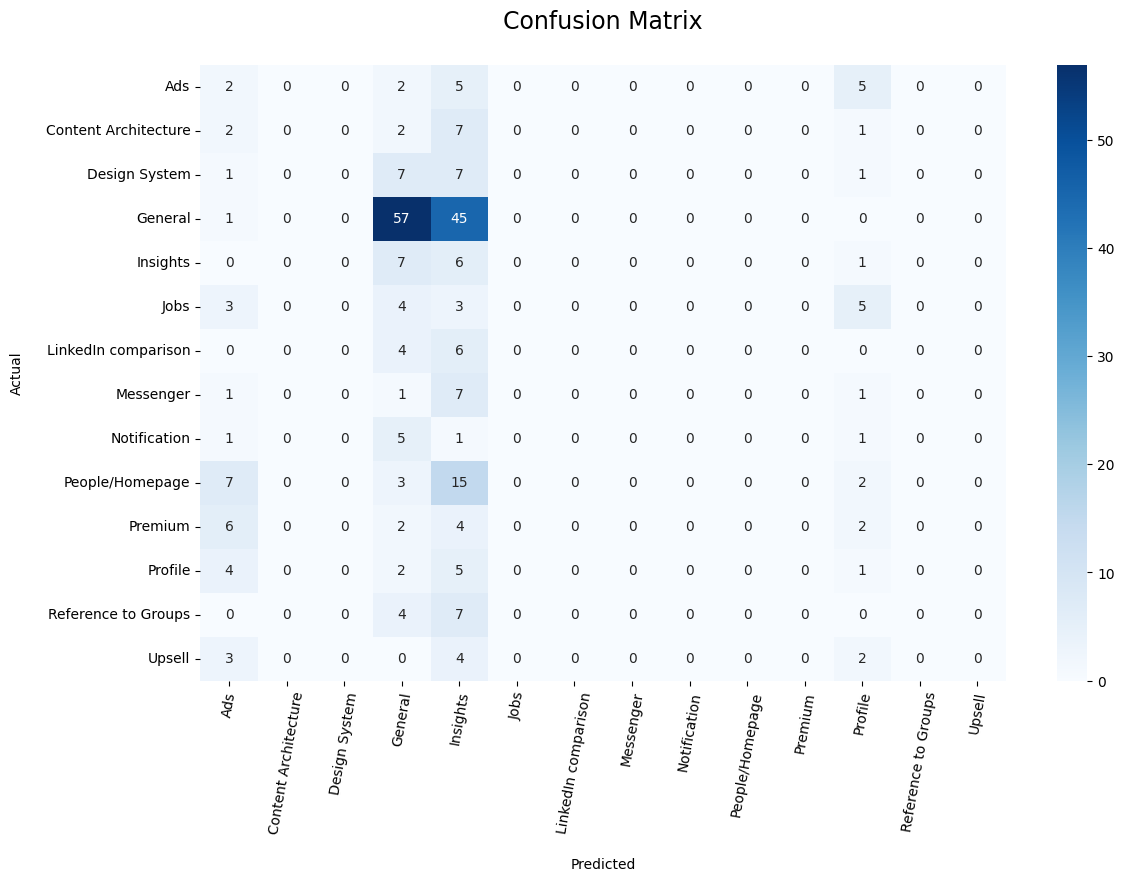

In [ ]:
cm = confusion_matrix(y_true = true_category, y_pred = predicted_category)
fig, ax = plt.subplots(figsize=(13,8))

sns.heatmap(cm, 
            annot = True, 
            cmap = "Blues", 
            xticklabels = list(encoded_classes),
            yticklabels = list(encoded_classes),
            )

plt.ylabel('Actual\n')
plt.xlabel('\nPredicted')
plt.xticks(rotation = 80)
plt.title("Confusion Matrix\n", size = 17);

In [ ]:
# To save the model
classifier.save_weights(filepath, save_format = 'tf')

In [ ]:
class BERT_Classification(tf.keras.Model):
    def __init__(self, BERT_model, num_classes, dropout_rate = 0.2):
        super().__init__()
        self.BERT = BERT_model
        self.dropout = tf.keras.layers.Dropout(rate = dropout_rate)
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')
        
    def call(self, inputs, training = False):
        x = self.BERT(inputs, training = training)[1]
        x = self.dropout(x, training = training)
        return self.fc(x)

with strategy.scope():
    model = TFAutoModel.from_pretrained("bert-base-uncased") # base version of BERT
    classifier1 = BERT_Classification(model, num_classes=14)

    classifier1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy', # for multiclass, single label classification
    metrics=[F1Score(num_classes=14, average="macro")]
    )

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
classifier1.load_weights(filepath)

In [ ]:
# preds = model.predict(test_dataset,verbose = 1) # making predictions
predictions = classifier1.predict(test_dataset,verbose = 1)
pred_classes = np.argmax(predictions, axis = 1) # converting the one hot vector output to a linear numpy array.

encoded_classes = encoder.classes_ # extracting the classes from the label encoder
predicted_category = [encoded_classes[x] for x in pred_classes] # mapping the encoded output to actual categories
true_category = [encoded_classes[x] for x in y_test]  

18/18 [==============================] - 21s 1s/step


# Hyperparamter Tuning

# Multilabel CLassification